In [33]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.full as si_full
import spikeinterface.preprocessing as spre
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import copy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.prepro import preprocess, trace_fitting
from src.nodes.dataeng.silico import recording



# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 20000          # sampling frequency
SFREQ_SILICO = 20000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad


# HORVATH (vivo)
# horvath (vivo)
EXPERIMENT_h_vivo = "vivo_horvath"
SIMULATION_h_vivo = "probe_1"
data_conf_h_vivo, param_conf_h_vivo = get_config(
    EXPERIMENT_h_vivo, SIMULATION_h_vivo
).values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
CONTACTS_h = np.arange(0,128,1)


# HORVATH (silico)
EXPERIMENT_h_silico = "silico_horvath"
SIMULATION_h_silico = "concatenated/probe_1"
data_conf_h_silico, param_conf_h_silico = get_config(
    EXPERIMENT_h_silico, SIMULATION_h_silico
).values()
RAW_PATH_h_silico = data_conf_h_silico["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
# MISSING_NOISE_PATH = data_conf_h_silico["preprocessing"]["fitting"]["missing_noise_path"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-12-19 15:03:06,168 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-19 15:03:06,178 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-19 15:03:06,179 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-19 15:03:06,190 - root - utils.py - get_config - INFO - Reading experiment config. - done


### If data already exists

In [ ]:
# # if already fitted results exist
# missing_noise_L1 = np.load(MISSING_NOISE_PATH + "L1.npy", allow_pickle=True).item()
# missing_noise_L2_3 = np.load(MISSING_NOISE_PATH + "L2_3.npy", allow_pickle=True).item()
# missing_noise_L4 = np.load(MISSING_NOISE_PATH + "L4.npy", allow_pickle=True).item()
# missing_noise_L5 = np.load(MISSING_NOISE_PATH + "L5.npy", allow_pickle=True).item()
# missing_noise_L6 = np.load(MISSING_NOISE_PATH + "L6.npy", allow_pickle=True).item()

# # store missing noises
# layers_missing_noise = (
#     missing_noise_L1,
#     missing_noise_L2_3,
#     missing_noise_L4,
#     missing_noise_L5,
#     missing_noise_L6,
# )

# # print
# print(layers_missing_noise)

### Custom functions

In [3]:
def get_layer_sites(silico_layers, layer: str = "L1"):
    if layer == "L2_3":
        return np.hstack(
            [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
        )
    else:
        return np.where(silico_layers == layer)[0]


def plot_example_one_sec_segments(traces, target_site=0, sfreq: int = 20000):
    """plot trace consecutive segments of one second
    Args:
        traces (np.ndarray): ntimepoints x n site traces
        target_site (np.ndarray): column index of a recording site
        sfreq (int): trace acquisition sampling frequency
    Return:
        plot
    """
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    winds = np.arange(0, 10, 1)
    for wind_i in winds:
        axes[wind_i].plot(traces[wind_i * sfreq : (wind_i + 1) * sfreq, target_site])
        axes[wind_i].set_ylim([-200, 200])
    return fig, axes


def measure_noise_at_consecutive_segs(traces, site, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq, site]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_trace_noise(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second

    Args:
        traces: 2D array
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_vivo_trace_noise_parallel(traces_vivo, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_vivo (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_vivo, SFREQ_VIVO, WIND_END))


def measure_silico_trace_noise_parallel(traces_silico, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_silico (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_silico, SFREQ_SILICO, WIND_END))


Nfeval = 1


def myfun(missing_mad_std, *args):
    # get arguments
    trace_silico = args[0]
    mad_vivo = args[1]
    site_silico = args[2]

    # calculate missing noise for this x
    missing_noise = np.random.normal(0, missing_mad_std, [trace_silico.shape[0], 1])

    # return objective function abs(mad_vivo - mad_silico) to minimize
    mad_silico = (
        pd.DataFrame(trace_silico[:, site_silico] + missing_noise.squeeze())
        .mad()
        .values
    )
    return abs(mad_vivo - mad_silico)


def myfun_layer(missing_noise, *args):
    # get args
    # - get in silico target site traces
    # - get in vivo layer noise
    traces = args[0]
    vivo_noise = args[1]
    ntimepoints = traces.shape[1]
    nsites = traces.shape[0]

    # try with this amount of missing uncorrelated noise in silico
    missing_noise_traces = np.random.normal(0, missing_noise, [nsites, ntimepoints])
    with_noise = traces + missing_noise_traces

    # measure site noises in that in silico layer
    with ProcessPoolExecutor() as executor:
        sites_noise = executor.map(
            measure_silico_trace_noise_parallel,
            with_noise,
            np.arange(0, nsites, 1),
        )

    # minimize noise difference between vivo and silico
    silico_noise = np.mean(np.array(list(sites_noise)))
    objfun = abs(vivo_noise - silico_noise)
    print("silico noise:", silico_noise)
    print("objfun:", objfun)
    return objfun


def callback(Xi):
    """callback function to print iterations_summary

    Args:
        Xi (_type_): missing noise (mad) parameter to solve
    """
    global Nfeval  # function evaluation
    print(Xi)
    print("{0:4d}   {1: 3.6f}".format(Nfeval, Xi[0]))
    Nfeval += 1


def sem(data):
    return np.std(data) / np.sqrt(len(data))


def conf_interv95(data):
    return 1.96 * sem(data)

In [34]:
# takes 1-2 mins

# - get max in vivo trace
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()

# - get max in silico trace
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
traces_silico = PreRecording_h_silico.get_traces()

In [5]:
# takes 6 min (instead of 2 hours)

# measure sites' noise in vivo (parallelized, )
with ProcessPoolExecutor() as executor:
    noise_by_trace = executor.map(
        measure_vivo_trace_noise_parallel,
        traces_vivo.T,
        np.arange(0, traces_vivo.shape[1], 1),
    )
vivo_noise_by_trace = list(noise_by_trace)

In [10]:
print(
    "max noise difference factor between sites:",
    np.max(vivo_noise_by_trace) / np.min(vivo_noise_by_trace),
)

max noise difference factor between sites: 2.141754078836378


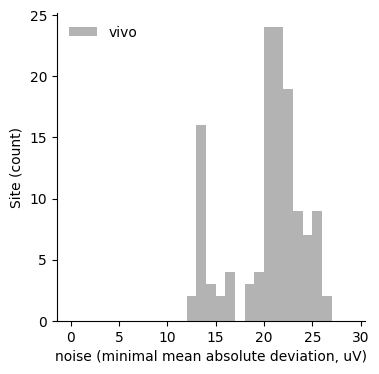

In [18]:
# PLOT
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# hist vivo
ax.hist(
    vivo_noise_by_trace, color=(0.7, 0.7, 0.7), label="vivo", bins=np.arange(0, 30, 1)
)

# legend
ax.set_ylabel("Site (count)")
ax.set_xlabel("noise (minimal mean absolute deviation, uV)")
ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)
ax.set_box_aspect(1)  # square axis

In [35]:
# sanity check that our sites are in layer 1 of the cortex
# - get layers
silico_layers = PreRecording_h_silico.get_property("layers")
vivo_layers = PreRecording_h_vivo.get_property("layers")

In [37]:
vivo_layers

array(['Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside',
       'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside',
       'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside',
       'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside',
       'Outside', 'Outside', 'Outside', 'Outside', 'Outside', 'Outside',
       'Outside', 'Outside', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1',
       'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1',
       'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1',
       'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L1', 'L2_3', 'L2_3', 'L2_3',
       'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3',
       'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3',
       'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3',
       'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3',
       'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3', 'L2_3'